[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 03 - VARIATIONAL AUTO ENCODER (VAE)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 3 – VARIATIONAL AUTO ENCODER (VAE)

1. Selecionar 2 datasets (rotulados)

2. Treinar modelos VAEs:

  2.1. Ajustar o melhor modelo (topologia) segundo a
função de custo (conjunto validação)

3. Explorar o espaço latente:

  3.1. Gerar gráficos com a projeção do espaço latente
em 2D (PCA)

  3.2 Usar os rótulos na projeção

### Algumas questões:

1. Há formação de clusters no espaço latente?

2. Há separação dos rótulos no espaço latente?

3. A projeção ilustra quanto da variância?

**Adicional (opcional)**: Enviesar a formação do
espaço latente com os exemplos rotulados


# Introduction 

O autoencoder é um algoritimo que possui uma extrutura arquitetônica semelhante ao 

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png">


<img src="https://uploads-ssl.webflow.com/5fff737782367c2909ecca82/602e565b1047f73f66f60f73_s-vae-gifs.gif">

font: https://en.wikipedia.org/wiki/Self-organizing_map


# Metodology 



## Parametes Explorations


## Datasets



## Plots and Results



## Extras



https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=4pVFzJmgngfE

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data



# Functions

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Plot Functions 

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    #plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    #plt.show()


# def plot_label_clusters(vae, data, labels):
#     # display a 2D plot of the digit classes in the latent space
#     z_mean, _, _ = vae.encoder.predict(data)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()

col_dict={0:"C0",
          1:"C1",
          2:"C2",
          3:"C3",
          4:"C4",
          5:"C5",
          6:"C6",
          7:"C7",
          8:"C8",
          9:"C9",
          }     
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])    

def plot_label_clusters(vae, data, labels,cmap=col_dict,s=cm,title=None):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,cmap=cmap,s=s,linewidths=0.3)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Model {title}')
    #plt.show()

# METRICS

def loss_plot(data,title=None,color='C0',linestyle=None):#,label=None):
  plt.plot(data,color=color,linestyle=linestyle)#,label=label)
  #title = None if title == None else ' Model '+title
  plt.title(f'Loss {title}')
  plt.xlabel('Epochs')
  #plt.legend()
  plt.ylabel('Score')
  plt.grid(alpha=0.5)

def recos_loss_plot(data,title=None,color='C1',linestyle=None):
  plt.plot(data,color=color,linestyle=linestyle)
  #title = None if title == None else ' Model '+title
  plt.title(f'Reconstruction Loss {title}')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.grid(alpha=0.5)

def kl_loss_plot(data,title=None,color='C2',linestyle=None,label=None):
  plt.plot(data,color=color,linestyle=linestyle,label=label)
  #title = None if title == None else ' Model '+title
  plt.title(f'Kl Loss {title}')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.grid(alpha=0.5)





#Datasets 


In [3]:
#dowloadind
data1 = keras.datasets.mnist.load_data()
data2 = keras.datasets.fashion_mnist.load_data()

(x_train1, _), (x_test1, _) = data1
mnist_digits1 = np.concatenate([x_train1, x_test1], axis=0)
mnist_digits1 = np.expand_dims(mnist_digits1, -1).astype("float32") / 255

(x_train2, _), (x_test2, _) = data2
mnist_digits2 = np.concatenate([x_train2, x_test2], axis=0)
mnist_digits2 = np.expand_dims(mnist_digits2, -1).astype("float32") / 255

# Experiment 1 - 2D Latent Space

## VAEs Models

In [4]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))

### Model 01

In [5]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder1 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
#x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder1 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

### Model 02

In [6]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder2 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder2 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

### Model 03

In [7]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder3 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder3 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

## Fit All Models

In [8]:
epochs = 30

# MNIST

vae1 = VAE(encoder1, decoder1)
vae1.compile(optimizer=keras.optimizers.Adam())
history1 = vae1.fit(mnist_digits1, epochs=epochs, batch_size=128)

vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam())
history2 = vae2.fit(mnist_digits1, epochs=epochs, batch_size=128)

vae3 = VAE(encoder3, decoder3)
vae3.compile(optimizer=keras.optimizers.Adam())
history3 = vae3.fit(mnist_digits1, epochs=epochs, batch_size=128)

# FASHION MNIST

vae4 = VAE(encoder1, decoder1)
vae4.compile(optimizer=keras.optimizers.Adam())
history4 = vae4.fit(mnist_digits2, epochs=epochs, batch_size=128)


vae5 = VAE(encoder2, decoder2)
vae5.compile(optimizer=keras.optimizers.Adam())
history5 = vae5.fit(mnist_digits2, epochs=epochs, batch_size=128)

vae6 = VAE(encoder3, decoder3)
vae6.compile(optimizer=keras.optimizers.Adam())
history6 = vae6.fit(mnist_digits2, epochs=epochs, batch_size=128)

Epoch 1/30
547/547 [==============================] - 29s 51ms/step - loss: 253.3903 - reconstruction_loss: 207.6343 - kl_loss: 3.2178
Epoch 2/30
547/547 [==============================] - 33s 59ms/step - loss: 188.8833 - reconstruction_loss: 181.3664 - kl_loss: 3.9485
Epoch 3/30
547/547 [==============================] - 30s 55ms/step - loss: 171.7630 - reconstruction_loss: 163.9152 - kl_loss: 5.6957
Epoch 4/30
547/547 [==============================] - 29s 53ms/step - loss: 165.9143 - reconstruction_loss: 159.0268 - kl_loss: 5.9345
Epoch 5/30
547/547 [==============================] - 31s 56ms/step - loss: 163.1787 - reconstruction_loss: 156.4936 - kl_loss: 6.0933
Epoch 6/30
547/547 [==============================] - 32s 59ms/step - loss: 161.4569 - reconstruction_loss: 154.7497 - kl_loss: 6.1515
Epoch 7/30
547/547 [==============================] - 33s 61ms/step - loss: 159.8628 - reconstruction_loss: 153.3808 - kl_loss: 6.1876
Epoch 8/30
547/547 [==============================] - 3

## Results

### Metriscs

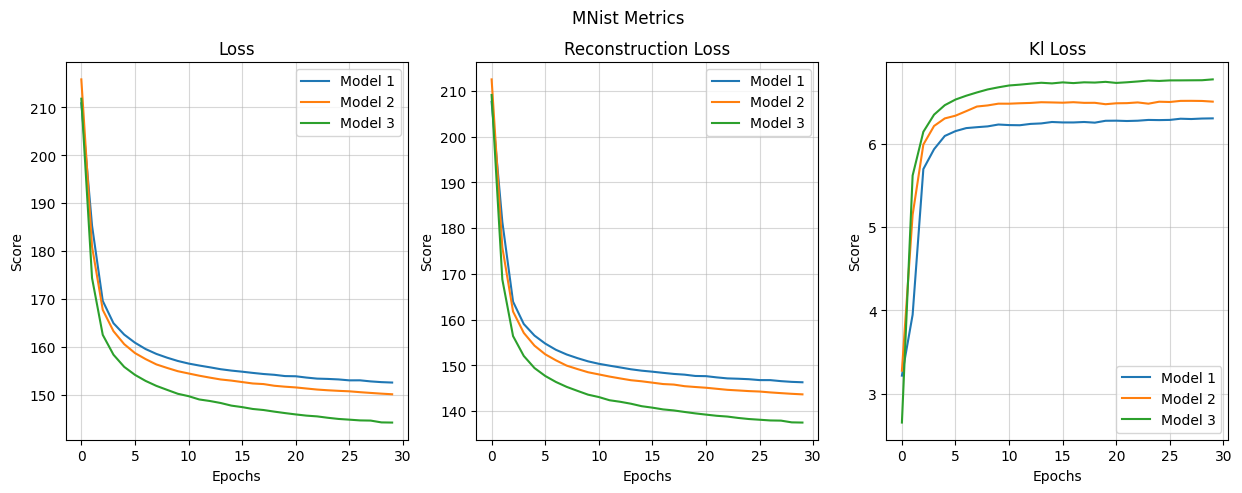

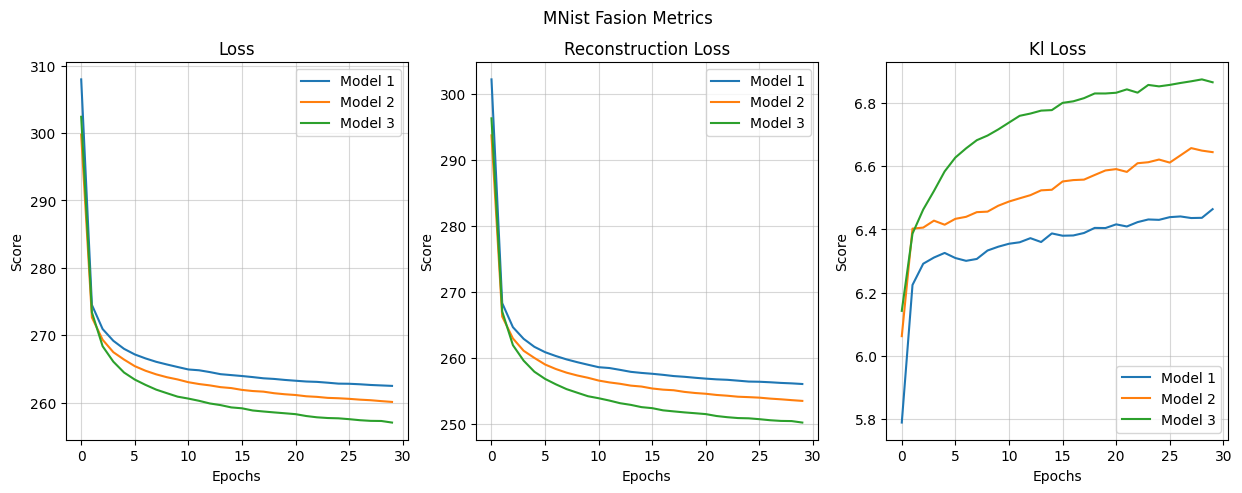

In [73]:
%matplotlib inline
history = [history1,history2,history3]#,history4,history5,history6]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

history = [history4,history5,history6]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Fasion Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

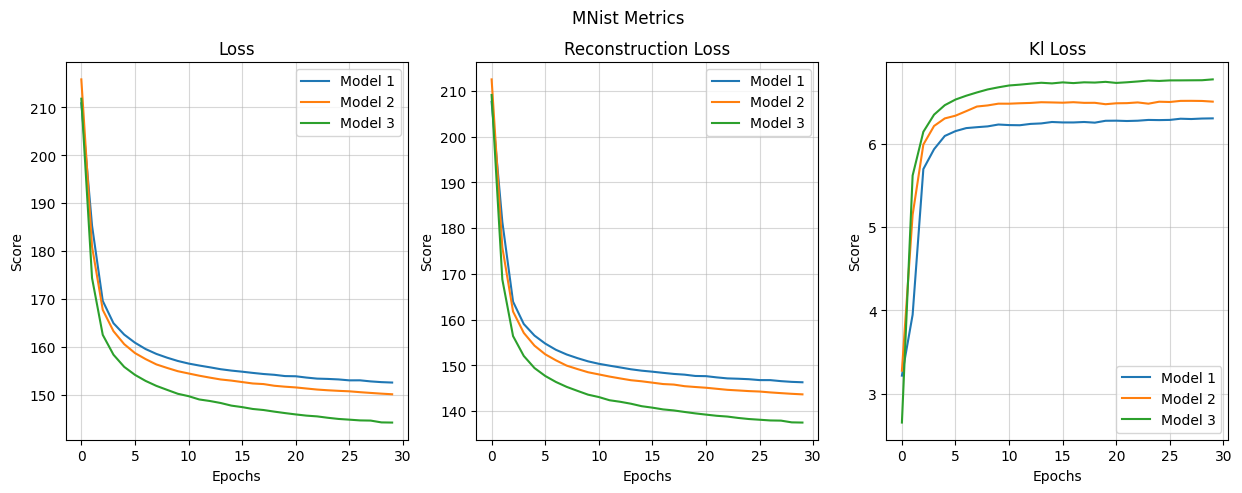

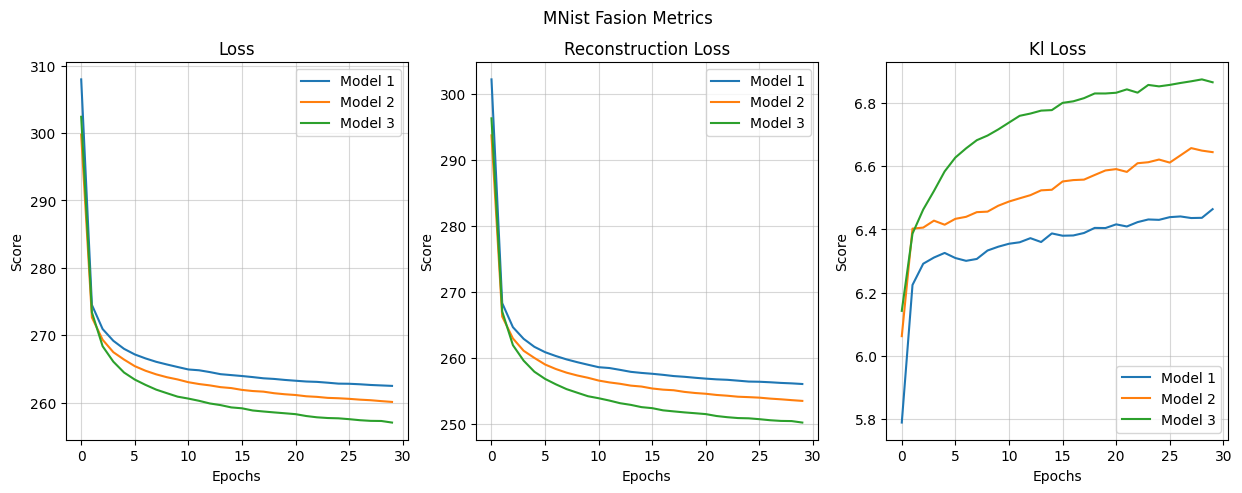

In [37]:
history = [history1,history2,history3]#,history4,history5,history6]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

history = [history4,history5,history6]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Fasion Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

1/1 [==============================] - 0s 36ms/step


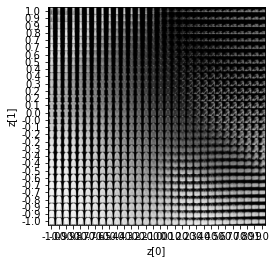

In [38]:
#plot 

plot_latent_space(vae1)


### Latent Space

In [39]:
(x_target1, y_target1), _ = data1
x_target1 = np.expand_dims(x_target1, -1).astype("float32") / 255

(x_target2, y_target2), _ = data2
x_target2 = np.expand_dims(x_target2, -1).astype("float32") / 255

1875/1875 [==============================] - 13s 7ms/step


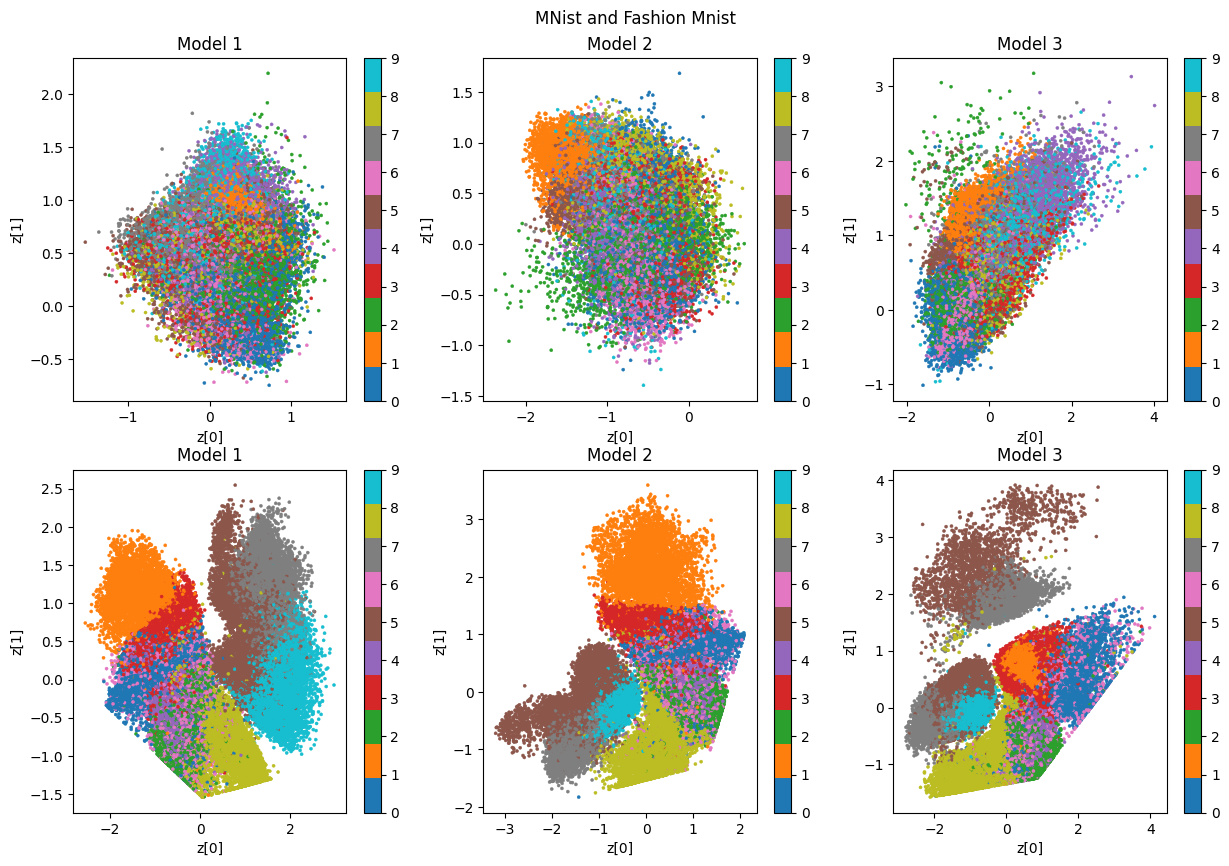

In [41]:

vaes = [vae1,vae2,vae3,vae4,vae5,vae6]
plt.figure(figsize=(15,10),dpi=100)
plt.suptitle('MNist and Fashion Mnist',  y=0.91, horizontalalignment='center', verticalalignment='bottom')

for i in range (0,3):
  plt.subplot(2,3,1+i)
  plot_label_clusters(vaes[i],x_target1,y_target1,cm,5,title = str(i+1))
for i in range (3,6):
  plt.subplot(2,3,1+i)
  plot_label_clusters(vaes[i],x_target2,y_target2,cm,5,title = str(i-2))

plt.show()

# Experiment 2 - 3D Latent Space

## VAEs Models

In [11]:
latent_dim = 3
encoder_inputs = keras.Input(shape=(28, 28, 1))

### Model 04

In [12]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder4 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
#x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder4 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

### Model 05

In [13]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder5 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder5 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

### Model 06

In [14]:
# Build the encoder
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder6 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder6 = keras.Model(latent_inputs, decoder_outputs, name="decoder")

## Fit All Models

In [15]:
epochs = 30

# MNIST

vae7 = VAE(encoder4, decoder4)
vae7.compile(optimizer=keras.optimizers.Adam())
history7 = vae7.fit(mnist_digits1, epochs=epochs, batch_size=128)

vae8 = VAE(encoder5, decoder5)
vae8.compile(optimizer=keras.optimizers.Adam())
history8 = vae8.fit(mnist_digits1, epochs=epochs, batch_size=128)

vae9 = VAE(encoder6, decoder6)
vae9.compile(optimizer=keras.optimizers.Adam())
history9 = vae9.fit(mnist_digits1, epochs=epochs, batch_size=128)

# FASHION MNIST

vae10 = VAE(encoder4, decoder4)
vae10.compile(optimizer=keras.optimizers.Adam())
history10 = vae10.fit(mnist_digits2, epochs=epochs, batch_size=128)


vae11 = VAE(encoder5, decoder5)
vae11.compile(optimizer=keras.optimizers.Adam())
history11 = vae11.fit(mnist_digits2, epochs=epochs, batch_size=128)

vae12 = VAE(encoder6, decoder6)
vae12.compile(optimizer=keras.optimizers.Adam())
history12 = vae12.fit(mnist_digits2, epochs=epochs, batch_size=128)

Epoch 1/30
547/547 [==============================] - 53s 96ms/step - loss: 261.9841 - reconstruction_loss: 208.6703 - kl_loss: 3.6830
Epoch 2/30
547/547 [==============================] - 55s 100ms/step - loss: 178.8230 - reconstruction_loss: 170.1246 - kl_loss: 5.6852
Epoch 3/30
547/547 [==============================] - 54s 99ms/step - loss: 170.2540 - reconstruction_loss: 163.1710 - kl_loss: 5.8771
Epoch 4/30
547/547 [==============================] - 54s 98ms/step - loss: 166.8592 - reconstruction_loss: 160.0176 - kl_loss: 6.0118
Epoch 5/30
547/547 [==============================] - 49s 90ms/step - loss: 164.5554 - reconstruction_loss: 158.1373 - kl_loss: 6.1092
Epoch 6/30
547/547 [==============================] - 50s 92ms/step - loss: 163.6276 - reconstruction_loss: 156.9929 - kl_loss: 6.1382
Epoch 7/30
547/547 [==============================] - 59s 108ms/step - loss: 162.3776 - reconstruction_loss: 156.1745 - kl_loss: 6.1455
Epoch 8/30
547/547 [==============================] -

## Results

### Metriscs

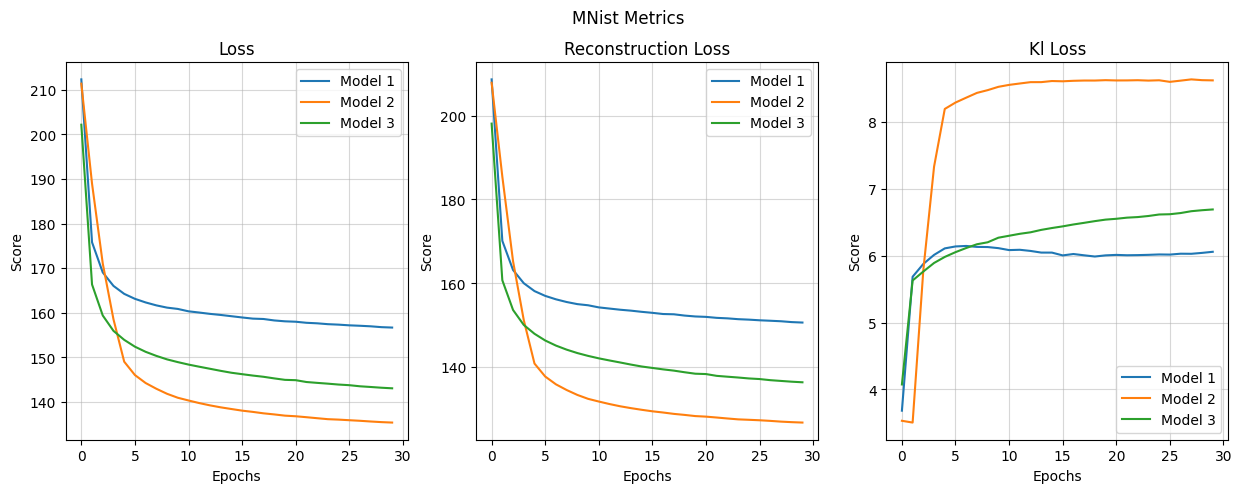

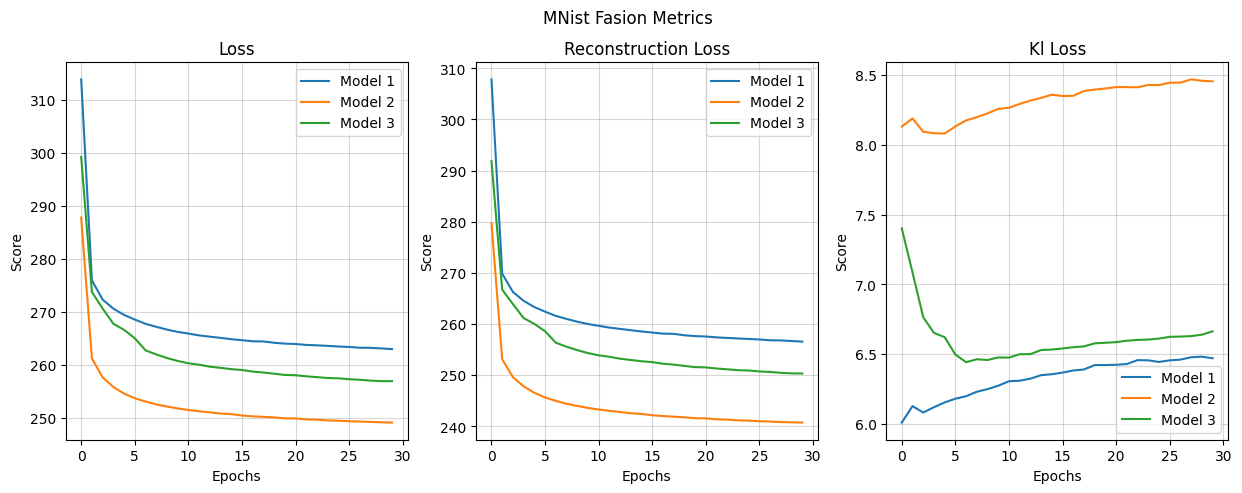

In [42]:
history = [history7,history8,history9]#,history4,history5,history6]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

history = [history10,history11,history12]

plt.figure(figsize=(15,5),dpi=100)
plt.suptitle('MNist Fasion Metrics',  y=0.95, horizontalalignment='center', verticalalignment='bottom')
plt.subplot(1,3,1)
for i in range(len(history)): plt.plot(history[i].history['loss'],label =f'Model {i+1}')
plt.title(f'Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Score')
plt.grid(alpha=0.5)

plt.subplot(1,3,2)
for i in range(len(history)): plt.plot(history[i].history['reconstruction_loss'],label =f'Model {i+1}')
plt.title(f'Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
for i in range(len(history)): plt.plot(history[i].history['kl_loss'],label =f'Model {i+1}')
plt.title(f'Kl Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

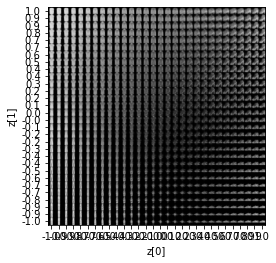

In [ ]:
#plot 

# plot_latent_space(vae1)


### Latent Space

In [81]:
(x_target1, y_target1), _ = data1
x_target1 = np.expand_dims(x_target1, -1).astype("float32") / 255

(x_target2, y_target2), _ = data2
x_target2 = np.expand_dims(x_target2, -1).astype("float32") / 255

In [51]:
#vaes = [vae7,vae8,vae9,va10,vae11,vae12]
z_mean, _, _ = vae7.encoder.predict(x_target1)    

1875/1875 [==============================] - 8s 4ms/step


In [62]:
X,Y,Z = z_mean[:, 0],z_mean[:, 1],z_mean[:, 2]

In [82]:
def plot_label_clusters(vae, data, labels,cmap=col_dict,s=cm,title=None):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,cmap=cmap,s=s,linewidths=0.3)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Model {title}')
    #plt.show()

col_dict={0:"C0",
          1:"C1",
          2:"C2",
          3:"C3",
          4:"C4",
          5:"C5",
          6:"C6",
          7:"C7",
          8:"C8",
          9:"C9",
          }     
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])    


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, c=y_target1, projection='3d')
ax.scatter(X, Y, Z,  cmap = cm)


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xs, ys, zs, marker=m)

plt.show()


AttributeError: 'Axes3DSubplot' object has no property 'c'

<Figure size 576x288 with 0 Axes>

In [83]:
y_target1

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
vaes = [vae7,vae8,vae9,vae10,vae11,vae12]
plt.figure(figsize=(15,10),dpi=100)
plt.suptitle('MNist and Fashion Mnist',  y=0.91, horizontalalignment='center', verticalalignment='bottom')

for i in range (0,3):
  plt.subplot(2,3,1+i)
  plot_label_clusters(vaes[i],x_target1,y_target1,cm,5,title = str(i+1))
for i in range (3,6):
  plt.subplot(2,3,1+i)
  plot_label_clusters(vaes[i],x_target2,y_target2,cm,5,title = str(i-2))

plt.show()

 919/1875 [=============>................] - ETA: 5s

# References

[HAYKIN, Simon. Redes Neurais: Princípios e prática. Porto Alegre
RS:Bookman, 2001.](https://www.amazon.com.br/Redes-Neurais-Princ%C3%ADpios-Simon-Haykin-ebook/dp/B073QSG69Y)

https://www.w3schools.com/python/python_classes.asp

https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73?gi=21e42fd28916

https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto4-autoencoder

https://www.kaggle.com/code/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

https://youtu.be/Ey8IZQl_lKs


